In [1]:
!conda install -y gdown -q

Retrieving notices: ...working... done
done
Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.13.1            |     pyhd8ed1ab_0          15 KB  conda-forge
    gdown-5.1.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.2.1              |       hd590300_1         2.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.8 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.13.1-pyhd8ed1ab_0 
  gdown              conda-forge/noarch::gdown-5.1.0-pyhd8ed1ab_0 

The following packages will be UPDATED:

  openssl                                  3.2.1-hd590300_0 --> 3.2.1-hd590300_1 




In [2]:
!gdown --id 1lJu60IG4eA3h9mjgiKn_mTLP10CDRns7
!unzip -qq dataset.zip

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1lJu60IG4eA3h9mjgiKn_mTLP10CDRns7
From (redirected): https://drive.google.com/uc?id=1lJu60IG4eA3h9mjgiKn_mTLP10CDRns7&confirm=t&uuid=ca11cb67-9583-4507-b717-f31600a593dc
To: /kaggle/working/dataset.zip
100%|███████████████████████████████████████| 1.13G/1.13G [00:04<00:00, 234MB/s]


In [3]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(64*36*18, 128)
        self.fc2 = nn.Linear(128, 3)

        self.relu = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, image: torch.Tensor) -> torch.Tensor:
        image = self.pool(self.relu(self.bn1(self.conv1(image))))
        image = self.pool(self.relu(self.bn2(self.conv2(image))))
        image = self.pool(self.relu(self.bn3(self.conv3(image))))
        image = image.view(-1, 64*36*18)
        image = self.dropout(self.relu(self.fc1(image)))
        image = self.fc2(image)
        return image

In [4]:
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample

train_path = 'dataset/train'
val_path = 'dataset/val'
batch_size = 128
learning_rate = 1e-3
weight_decay = 2e-5
num_epochs = 75
transform = transforms.Compose([transforms.Grayscale(), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5)])
train_data = datasets.DatasetFolder(root=train_path, loader=npy_loader, extensions='.npy', transform=transform)
print('Training Classes: ' + str(train_data.class_to_idx))
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_data = datasets.DatasetFolder(root=val_path, loader=npy_loader, extensions='.npy')
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)

Training Classes: {'no': 0, 'sphere': 1, 'vort': 2}


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [6]:
model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    total = 0.0
    correct = 0.0
    for data, target in tqdm(trainloader):
        data = data.to(device).float()
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total += target.size(0)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(trainloader.dataset)
    acc = 100 * correct / total
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tTest Acc: {acc:.3f}')

100%|██████████| 235/235 [00:22<00:00, 10.46it/s]


Epoch: 1 	Training Loss: 1.343591 	Test Acc: 33.270


100%|██████████| 235/235 [00:20<00:00, 11.26it/s]


Epoch: 2 	Training Loss: 1.105216 	Test Acc: 33.163


100%|██████████| 235/235 [00:20<00:00, 11.22it/s]


Epoch: 3 	Training Loss: 1.103519 	Test Acc: 33.487


100%|██████████| 235/235 [00:20<00:00, 11.25it/s]


Epoch: 4 	Training Loss: 1.102441 	Test Acc: 33.727


100%|██████████| 235/235 [00:20<00:00, 11.22it/s]


Epoch: 5 	Training Loss: 1.102401 	Test Acc: 33.900


100%|██████████| 235/235 [00:20<00:00, 11.22it/s]


Epoch: 6 	Training Loss: 1.100917 	Test Acc: 33.750


100%|██████████| 235/235 [00:20<00:00, 11.25it/s]


Epoch: 7 	Training Loss: 1.100830 	Test Acc: 33.790


100%|██████████| 235/235 [00:20<00:00, 11.23it/s]


Epoch: 8 	Training Loss: 1.100404 	Test Acc: 34.187


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 9 	Training Loss: 1.101086 	Test Acc: 33.927


100%|██████████| 235/235 [00:20<00:00, 11.22it/s]


Epoch: 10 	Training Loss: 1.099424 	Test Acc: 34.190


100%|██████████| 235/235 [00:20<00:00, 11.24it/s]


Epoch: 11 	Training Loss: 1.100973 	Test Acc: 34.173


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 12 	Training Loss: 1.100117 	Test Acc: 33.920


100%|██████████| 235/235 [00:20<00:00, 11.22it/s]


Epoch: 13 	Training Loss: 1.099111 	Test Acc: 34.240


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 14 	Training Loss: 1.098706 	Test Acc: 34.740


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 15 	Training Loss: 1.100028 	Test Acc: 33.820


100%|██████████| 235/235 [00:20<00:00, 11.22it/s]


Epoch: 16 	Training Loss: 1.098896 	Test Acc: 34.680


100%|██████████| 235/235 [00:21<00:00, 11.18it/s]


Epoch: 17 	Training Loss: 1.099705 	Test Acc: 34.713


100%|██████████| 235/235 [00:20<00:00, 11.23it/s]


Epoch: 18 	Training Loss: 1.097873 	Test Acc: 35.053


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 19 	Training Loss: 1.097579 	Test Acc: 35.357


100%|██████████| 235/235 [00:20<00:00, 11.22it/s]


Epoch: 20 	Training Loss: 1.096843 	Test Acc: 35.607


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 21 	Training Loss: 1.098952 	Test Acc: 35.440


100%|██████████| 235/235 [00:20<00:00, 11.22it/s]


Epoch: 22 	Training Loss: 1.098454 	Test Acc: 34.873


100%|██████████| 235/235 [00:20<00:00, 11.26it/s]


Epoch: 23 	Training Loss: 1.097257 	Test Acc: 35.253


100%|██████████| 235/235 [00:20<00:00, 11.22it/s]


Epoch: 24 	Training Loss: 1.096179 	Test Acc: 35.813


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 25 	Training Loss: 1.096073 	Test Acc: 35.927


100%|██████████| 235/235 [00:20<00:00, 11.25it/s]


Epoch: 26 	Training Loss: 1.093903 	Test Acc: 36.487


100%|██████████| 235/235 [00:21<00:00, 11.16it/s]


Epoch: 27 	Training Loss: 1.092860 	Test Acc: 37.047


100%|██████████| 235/235 [00:20<00:00, 11.25it/s]


Epoch: 28 	Training Loss: 1.093027 	Test Acc: 36.993


100%|██████████| 235/235 [00:20<00:00, 11.20it/s]


Epoch: 29 	Training Loss: 1.092796 	Test Acc: 37.047


100%|██████████| 235/235 [00:20<00:00, 11.22it/s]


Epoch: 30 	Training Loss: 1.092436 	Test Acc: 37.137


100%|██████████| 235/235 [00:20<00:00, 11.19it/s]


Epoch: 31 	Training Loss: 1.073959 	Test Acc: 39.977


100%|██████████| 235/235 [00:21<00:00, 11.18it/s]


Epoch: 32 	Training Loss: 1.045157 	Test Acc: 43.060


100%|██████████| 235/235 [00:21<00:00, 11.18it/s]


Epoch: 33 	Training Loss: 1.018209 	Test Acc: 45.577


100%|██████████| 235/235 [00:21<00:00, 11.17it/s]


Epoch: 34 	Training Loss: 0.981982 	Test Acc: 48.633


100%|██████████| 235/235 [00:20<00:00, 11.20it/s]


Epoch: 35 	Training Loss: 0.929823 	Test Acc: 53.183


100%|██████████| 235/235 [00:20<00:00, 11.20it/s]


Epoch: 36 	Training Loss: 0.899020 	Test Acc: 55.267


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 37 	Training Loss: 0.840321 	Test Acc: 59.247


100%|██████████| 235/235 [00:21<00:00, 11.18it/s]


Epoch: 38 	Training Loss: 0.797985 	Test Acc: 62.560


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 39 	Training Loss: 0.757858 	Test Acc: 64.887


100%|██████████| 235/235 [00:21<00:00, 11.12it/s]


Epoch: 40 	Training Loss: 0.721660 	Test Acc: 67.053


100%|██████████| 235/235 [00:20<00:00, 11.20it/s]


Epoch: 41 	Training Loss: 0.666366 	Test Acc: 70.363


100%|██████████| 235/235 [00:20<00:00, 11.19it/s]


Epoch: 42 	Training Loss: 0.638637 	Test Acc: 71.790


100%|██████████| 235/235 [00:20<00:00, 11.25it/s]


Epoch: 43 	Training Loss: 0.608219 	Test Acc: 73.760


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 44 	Training Loss: 0.571557 	Test Acc: 75.373


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 45 	Training Loss: 0.551507 	Test Acc: 76.303


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 46 	Training Loss: 0.521527 	Test Acc: 78.267


100%|██████████| 235/235 [00:20<00:00, 11.24it/s]


Epoch: 47 	Training Loss: 0.507266 	Test Acc: 78.967


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 48 	Training Loss: 0.482030 	Test Acc: 80.057


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 49 	Training Loss: 0.456749 	Test Acc: 81.093


100%|██████████| 235/235 [00:20<00:00, 11.22it/s]


Epoch: 50 	Training Loss: 0.445118 	Test Acc: 81.933


100%|██████████| 235/235 [00:20<00:00, 11.19it/s]


Epoch: 51 	Training Loss: 0.429324 	Test Acc: 82.707


100%|██████████| 235/235 [00:20<00:00, 11.23it/s]


Epoch: 52 	Training Loss: 0.407764 	Test Acc: 83.507


100%|██████████| 235/235 [00:20<00:00, 11.22it/s]


Epoch: 53 	Training Loss: 0.389973 	Test Acc: 84.417


100%|██████████| 235/235 [00:20<00:00, 11.22it/s]


Epoch: 54 	Training Loss: 0.384490 	Test Acc: 84.570


100%|██████████| 235/235 [00:20<00:00, 11.23it/s]


Epoch: 55 	Training Loss: 0.360205 	Test Acc: 85.563


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 56 	Training Loss: 0.352959 	Test Acc: 86.090


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 57 	Training Loss: 0.345726 	Test Acc: 86.590


100%|██████████| 235/235 [00:21<00:00, 11.18it/s]


Epoch: 58 	Training Loss: 0.329445 	Test Acc: 87.093


100%|██████████| 235/235 [00:20<00:00, 11.22it/s]


Epoch: 59 	Training Loss: 0.321560 	Test Acc: 87.330


100%|██████████| 235/235 [00:20<00:00, 11.20it/s]


Epoch: 60 	Training Loss: 0.309084 	Test Acc: 87.930


100%|██████████| 235/235 [00:20<00:00, 11.22it/s]


Epoch: 61 	Training Loss: 0.310529 	Test Acc: 88.157


100%|██████████| 235/235 [00:21<00:00, 11.18it/s]


Epoch: 62 	Training Loss: 0.291396 	Test Acc: 88.797


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Epoch: 63 	Training Loss: 0.281720 	Test Acc: 89.087


100%|██████████| 235/235 [00:20<00:00, 11.20it/s]


Epoch: 64 	Training Loss: 0.276851 	Test Acc: 89.250


100%|██████████| 235/235 [00:20<00:00, 11.26it/s]


Epoch: 65 	Training Loss: 0.270488 	Test Acc: 89.607


100%|██████████| 235/235 [00:20<00:00, 11.20it/s]


Epoch: 66 	Training Loss: 0.257127 	Test Acc: 90.210


100%|██████████| 235/235 [00:21<00:00, 11.18it/s]


Epoch: 67 	Training Loss: 0.248505 	Test Acc: 90.647


100%|██████████| 235/235 [00:20<00:00, 11.25it/s]


Epoch: 68 	Training Loss: 0.242623 	Test Acc: 90.670


100%|██████████| 235/235 [00:20<00:00, 11.24it/s]


Epoch: 69 	Training Loss: 0.236454 	Test Acc: 90.890


100%|██████████| 235/235 [00:20<00:00, 11.20it/s]


Epoch: 70 	Training Loss: 0.233044 	Test Acc: 91.093


100%|██████████| 235/235 [00:20<00:00, 11.24it/s]


Epoch: 71 	Training Loss: 0.221028 	Test Acc: 91.660


100%|██████████| 235/235 [00:20<00:00, 11.24it/s]


Epoch: 72 	Training Loss: 0.213000 	Test Acc: 91.810


100%|██████████| 235/235 [00:20<00:00, 11.23it/s]


Epoch: 73 	Training Loss: 0.208985 	Test Acc: 92.167


100%|██████████| 235/235 [00:20<00:00, 11.24it/s]


Epoch: 74 	Training Loss: 0.196582 	Test Acc: 92.587


100%|██████████| 235/235 [00:20<00:00, 11.19it/s]

Epoch: 75 	Training Loss: 0.205641 	Test Acc: 92.227


In [7]:
y_test, predictions = [], []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(valloader):
        images = images.to(device).float()
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_test.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
    acc = 100 * correct / total
    print(
        f'Accuracy of the network on the {total} test images: '
        f'{acc:.3f} %'
    )

100%|██████████| 59/59 [00:02<00:00, 23.82it/s]

Accuracy of the network on the 7500 test images: 83.960 %


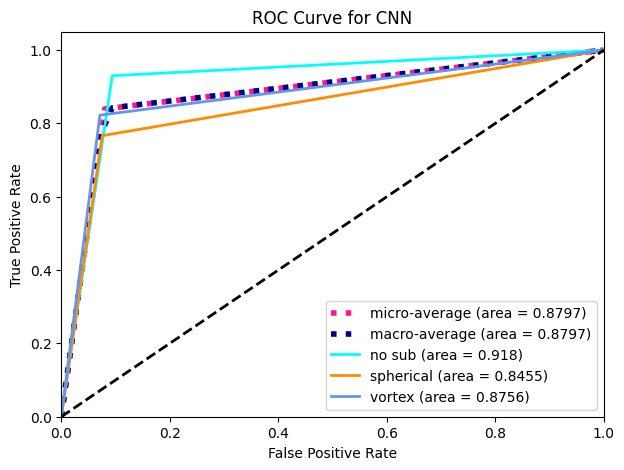

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

n_classes = 3

pred = label_binarize(predictions, classes=[0,1,2])
y = label_binarize(y_test, classes=[0,1,2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams['figure.figsize'] = [7, 5]
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {})'
               ''.format(round(roc_auc["micro"],5)),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {})'
               ''.format(round(roc_auc["macro"],5)),
         color='navy', linestyle=':', linewidth=4)

labels = ['no sub', 'spherical', 'vortex']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{} (area = {})'
             ''.format(labels[i], round(roc_auc[i],5)))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc="lower right", prop={"size":10})
plt.savefig('roc-auc-final.png', dpi=500)

In [9]:
torch.save(model.state_dict(), "my_cnn_final.pth")